# What happens if I fit a mass-gainer with single star models?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import linear_sum_assignment
import astropy.units as u
from itertools import product
from uncertainties import unumpy

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [3]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid);

sys.path.append("../helpers")
import mpt

In [4]:
from types import ModuleType
def refresh_mpt():
    rreload(mpt)
    rreload(mpt)

def rreload(module):
    """Recursively reload modules."""
    reload(module)
    for attribute_name in dir(module):
        attribute = getattr(module, attribute_name)
        if type(attribute) is ModuleType:
            if attribute_name in ["hr", "profiles", "period_spacing", "utils"]:
                rreload(attribute)

In [5]:
track = mesagrid.Track("../output/binaries/D_20", dir_name="LOGS_star2", parameters="Mass-gainer")

In [6]:
single_tracks = {}
Ms = np.arange(2.0, 6.1, 0.1)
for M in Ms:
    folder = f"M_{M:1.1f}"
    single_tracks[folder] = mesagrid.Track(dir=f"../output/singles/D_20/{folder}", parameters=folder)
mod_names = [f"M_{M:1.1f}" for M in Ms]

In [11]:
def chi_chains(p_s, p_mg=None, x=None, p_min=1.0, p_max=3.0, longest_chain=False, chain_min=2, reduced=False):
    """Calculate chi^2, aligning periods based on chains of consecutive radial order

    For each chain of consecutive radial order (i.e. subsequent single star period matches subsequent
    mass-gainer period), calculate its length and reduced chi^2. Then pick either the
    longest or lower chi^2 chain to align the rest of the pattern.

    Parameters
    ----------
    p_s : `np.ndarray`
        Single star periods
    p_mg : `np.ndarray`, optional
        Mass-gainer periods, by default None
    x : `np.array`, optional
        Sorted and masked mass-gainer periods (for speed-ups), by default None
    p_min : `float`, optional
        Minimum period, by default 1.0
    p_max : `float`, optional
        Maximum period, by default 3.0
    longest_chain : `bool`, optional
        Whether to use the longest chain instead of minimum chi^2 chain, by default False
    chain_min : `int`, optional
        Minimum length of a chain, by default 1

    Returns
    -------
    chi2 : `float`
        Reduced chi^2 value
    """
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods, remove units, limit period range
        p_mg = np.sort(p_mg.to(u.d).value)
        p_mg = p_mg[(p_mg > p_min) & (p_mg <= p_max)]
    else:
        p_mg = x

    # sort single star periods, remove units, limit period range
    p_s = np.sort(p_s.to(u.d).value)
    p_s = p_s[(p_s > p_min) & (p_s <= p_max)]

    # convert to frequency and back to period with uncertainties
    f_mg = 1 / p_mg
    f_mg_with_unc = unumpy.uarray(f_mg, np.ones(len(f_mg)) / 1150)
    p_mg_with_unc = 1 / f_mg_with_unc
    sigmas = unumpy.std_devs(p_mg_with_unc)

    # indices of closest single star periods to each mass-gainer period
    inds_s = np.asarray([np.argmin(np.abs(p_s - p)) for p in p_mg])

    # empty arrays for storing length and chi2 of chains, cursor for tracking
    # arrays are way too big to avoid growing them, will trim after
    BIG_BUT_RANDOM_NUMBER = 1000
    lengths = np.zeros(BIG_BUT_RANDOM_NUMBER).astype(int)
    chi2 =  np.zeros(BIG_BUT_RANDOM_NUMBER)
    offsets = np.zeros(BIG_BUT_RANDOM_NUMBER).astype(int)
    cursor = 0

    ## we are going to loop over the indices and sum chi^2 for contiguous blocks, storing that chi^2 + length
    # base condition
    lengths[0] += 1
    chi2[0] += (p_s[inds_s[0]] - p_mg[0])**2
    offsets[0] = inds_s[0]

    # step through each mass-gainer period
    for i in range(1, len(p_mg)):
        # if the closest single star period is not *also* the next radial order then start a new chain
        if inds_s[i] - inds_s[i - 1] != 1:
            cursor += 1
            offsets[cursor] = inds_s[i] - i

        # increment the length of the current chain and add to its chi^2
        lengths[cursor] += 1
        chi2[cursor] += (p_s[inds_s[i]] - p_mg[i])**2 / sigmas[i]**2
    # avoid off-by-one errors
    cursor += 1

    # trim useless empty part of arrays as promised
    chi2 = chi2[:cursor]
    lengths = lengths[:cursor]
    offsets = offsets[:cursor]

    # keep only chains with at least two periods
    chi2 = chi2[lengths >= chain_min]
    offsets = offsets[lengths >= chain_min]
    lengths = lengths[lengths >= chain_min]

    # convert to reduced chi2
    reduced_chi2 = chi2 / (lengths - 1)

    # just in case no chains were found
    if len(reduced_chi2) < 1:
        return 1e10

    # work out the offset between indices based either on the longest chain or just the minimum chi^2
    offset = offsets[np.argmax(lengths) if longest_chain else np.argmin(reduced_chi2)]

    # use offset to work out the matched indices
    matched_mg_inds = np.arange(len(p_mg))
    matched_s_inds = matched_mg_inds + offset

    # mask the indices (relevant in cases where there are fewer modes in single star model)
    allowed = (matched_s_inds >= 0) & (matched_s_inds < len(p_s))
    matched_mg_inds = matched_mg_inds[allowed]
    matched_s_inds = matched_s_inds[allowed]

    if reduced:
        return sum((p_mg[matched_mg_inds] - p_s[matched_s_inds])**2 / sigmas[matched_mg_inds]) / (len(matched_s_inds) - 1)
    else:
        return sum((p_mg[matched_mg_inds] - p_s[matched_s_inds])**2 / sigmas[matched_mg_inds])

p_mg, _, _ = mpt.get_delta_p(track, X_c=0.1)
p_s = mpt.get_delta_p(single_tracks["M_3.0"], mod=91)[0]

chi_chains(p_s, p_mg, chain_min=1)

/tmp/ipykernel_346008/3241893831.py:89: RuntimeWarning: divide by zero encountered in divide
  reduced_chi2 = chi2 / (lengths - 1)


6.032447433500314

In [15]:
def get_all_chis(X_c=0.2, reduced=False):
    p_mg, _, _ = mpt.get_delta_p(track, X_c=X_c)
    p_mg = np.sort(p_mg.to(u.d).value)
    x = p_mg[(p_mg > 1.0) & (p_mg <= 3.0)]

    return [[chi_chains(p_s=mpt.get_delta_p(single_tracks[mod_name], mod=i)[0], x=x, reduced=reduced)
             for i in range(len(single_tracks[mod_name].freqs))] for mod_name in mod_names]

In [19]:
cmap = plt.get_cmap('cividis_r').copy()
cmap.set_extremes(under='white', bad="black")

In [21]:
def plot_chis(chis, X_c, truth_col='pink', best_fit_col='cyan'):
    x_cs = [single_tracks[mod_name].history["center_h1"].values for mod_name in mod_names]

    chi_funcs = [interp1d(x_c, np.array(chi), fill_value="extrapolate") for x_c, chi in zip(x_cs, chis)]

    x_c_range = np.linspace(1e-5, 0.698, 200)

    XC, M = np.meshgrid(x_c_range, Ms)

    CHI = np.asarray([chi_funcs[i](x_c_range) for i in range(len(chi_funcs))])
    CHI[CHI > 100000] = np.inf

    print(np.log10(CHI).min(), np.log10(CHI).max())

    fig, ax = plt.subplots()

    levels = np.linspace(0, 3, 16)
    cont = ax.contourf(XC, M, np.log10(CHI), levels=levels, cmap=cmap, vmin=0.0, extend='both')
    # ax.contour(XC, M, np.log10(CHI), levels=[np.log10(43)], colors="white", zorder=10)
    for c in cont.collections:
        c.set_edgecolor("face")
        c.set_rasterized(True)
    fig.colorbar(cont, label=r"$\log_{10}(\chi^2)$")

    M_ind, x_c_ind = np.unravel_index(np.argmin(CHI), CHI.shape)

    print(X_c, f'{x_c_range[x_c_ind]:1.3f}', f'{Ms[M_ind]:1.3f}')

    xlims, ylims = ax.get_xlim(), ax.get_ylim()

    lw, ls, bf_ls = 2, "-", '-'

    ax.plot([X_c, X_c], [2.0, 3.5], color=truth_col, linestyle=ls, lw=lw,
            label=r"Truth ($X_c = $" + f"{X_c}, " + r"$M = $" + "3.5)")
    ax.plot([0, X_c], [3.5, 3.5], color=truth_col, linestyle=ls, lw=lw)
    ax.scatter(X_c, 3.5, color=truth_col, s=35)

    ax.plot([x_c_range[x_c_ind], x_c_range[x_c_ind]], [2.0, Ms[M_ind]], color=best_fit_col, linestyle=bf_ls, lw=lw,
            label=r"Best fit ($X_c = $" + f"{x_c_range[x_c_ind]:1.2f}, " + r"$M = $" + f"{Ms[M_ind]:1.1f})")
    ax.plot([0, x_c_range[x_c_ind]], [Ms[M_ind], Ms[M_ind]], color=best_fit_col, linestyle=bf_ls, lw=lw)
    ax.scatter(x_c_range[x_c_ind], Ms[M_ind], color=best_fit_col, s=35)

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlim(left=2.5e-3)

    ax.legend(loc="best", framealpha=0.1, labelcolor="white", fontsize=0.7*fs)

    ax.set_xlabel(r"Central hydrogen fraction, $X_c$", fontsize=fs)
    ax.set_ylabel(r"Stellar mass, $M \, [\rm M_\odot]$", fontsize=fs)

    plt.savefig(f"../paper/figures/chi2_xc_{X_c}.pdf", format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

In [16]:
chis = get_all_chis(X_c=0.1)

-0.5739485392139594 inf
0.1 0.260 3.000


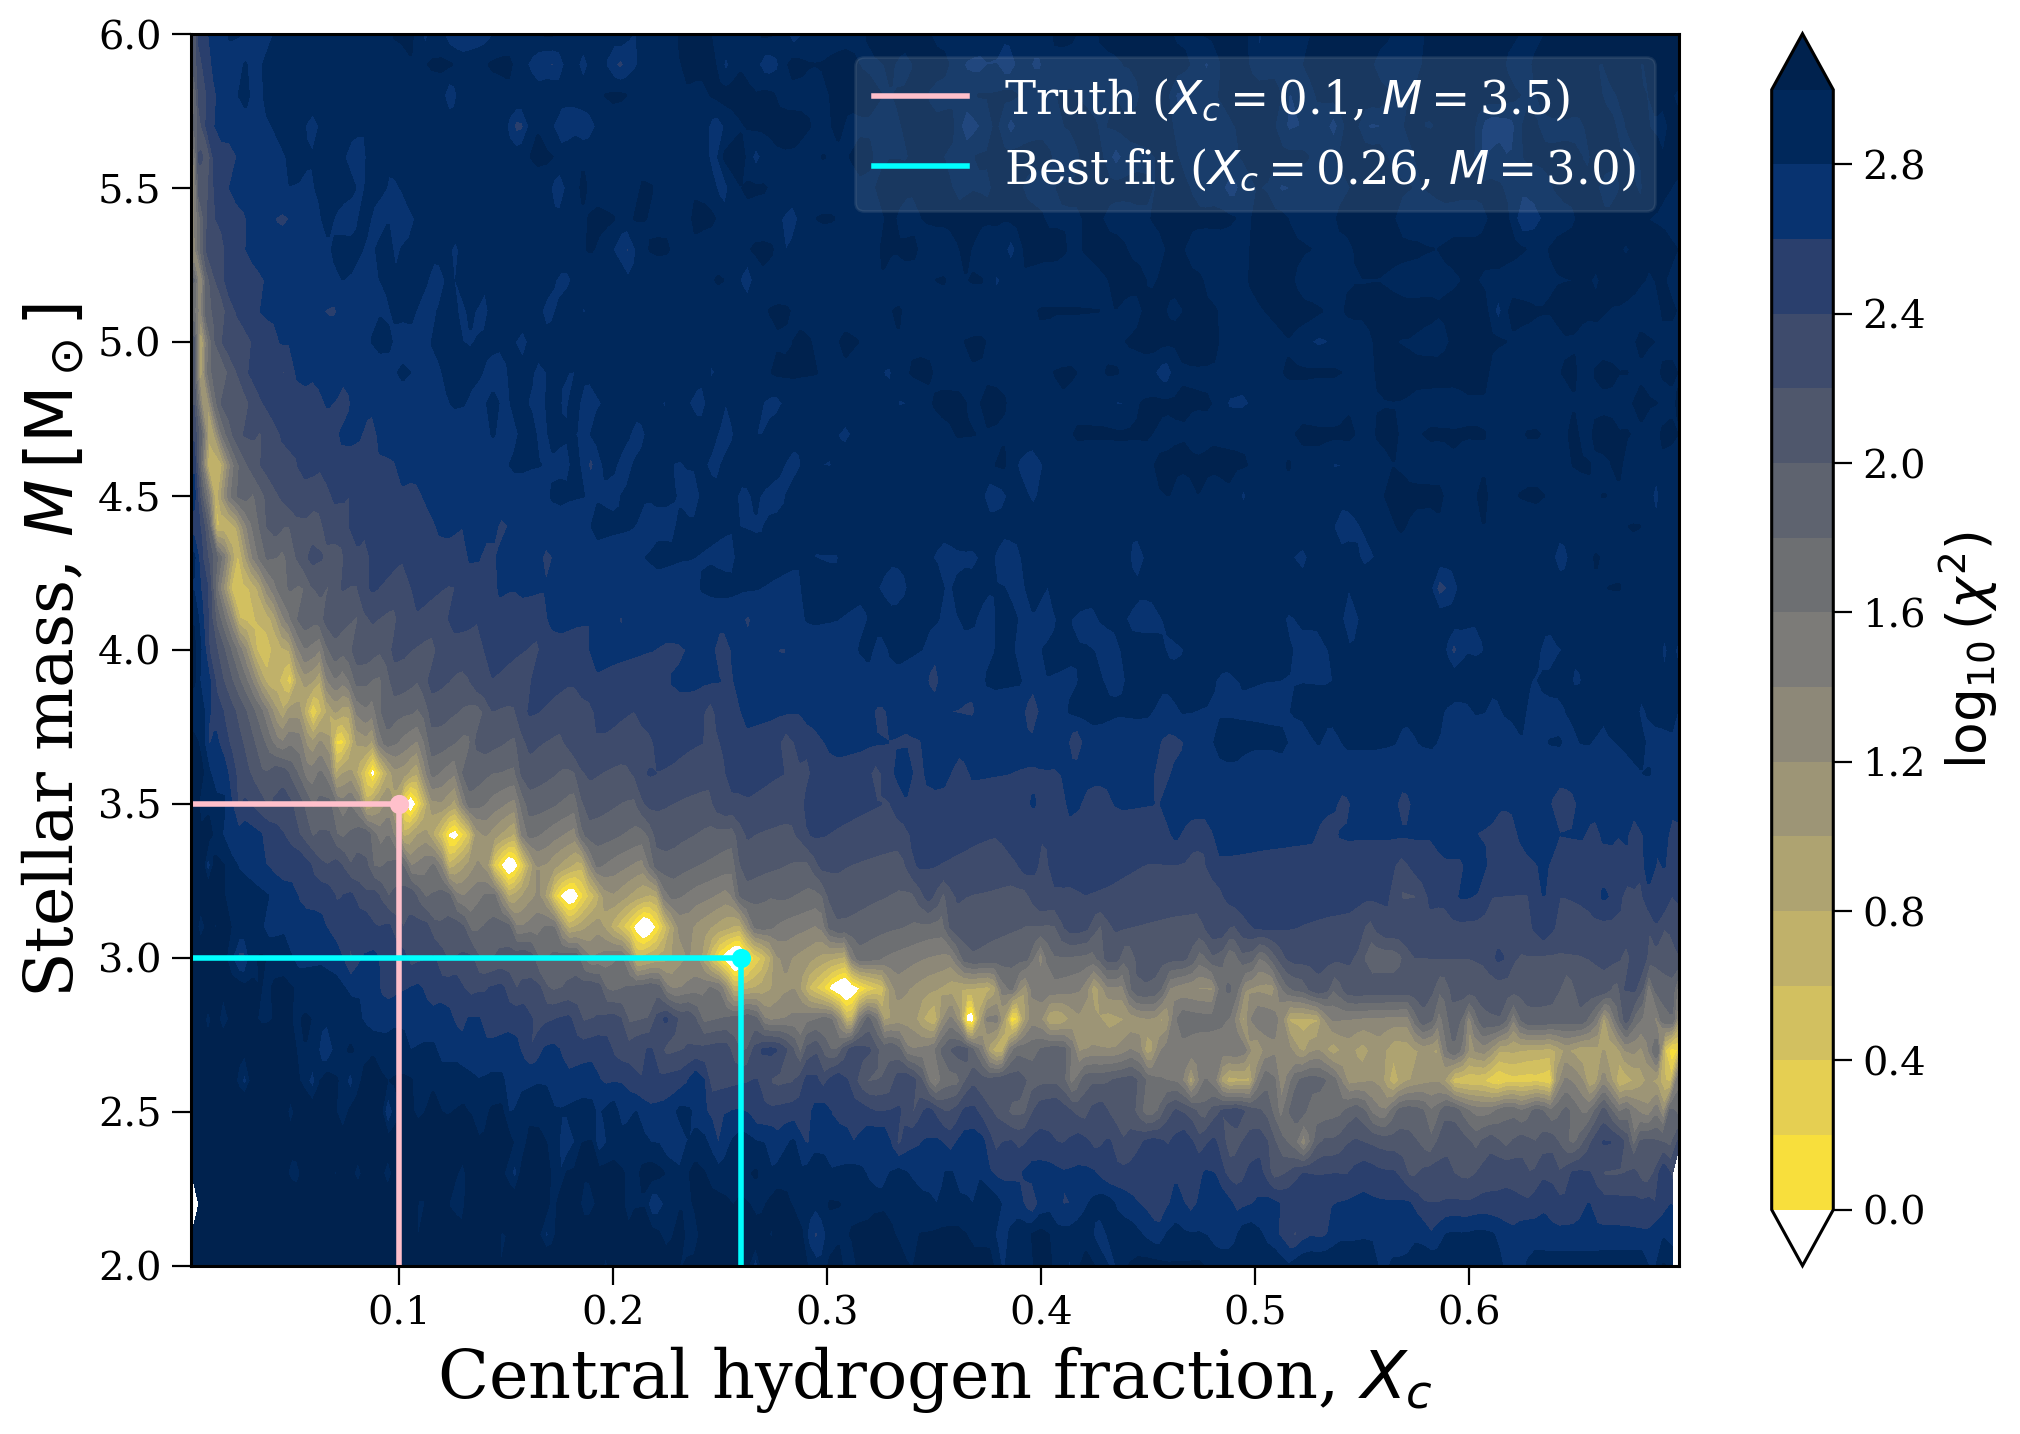

In [22]:
plot_chis(chis, X_c=0.1, truth_col="pink", best_fit_col='cyan')

-0.23324606133045378 inf
0.47 0.642 3.500


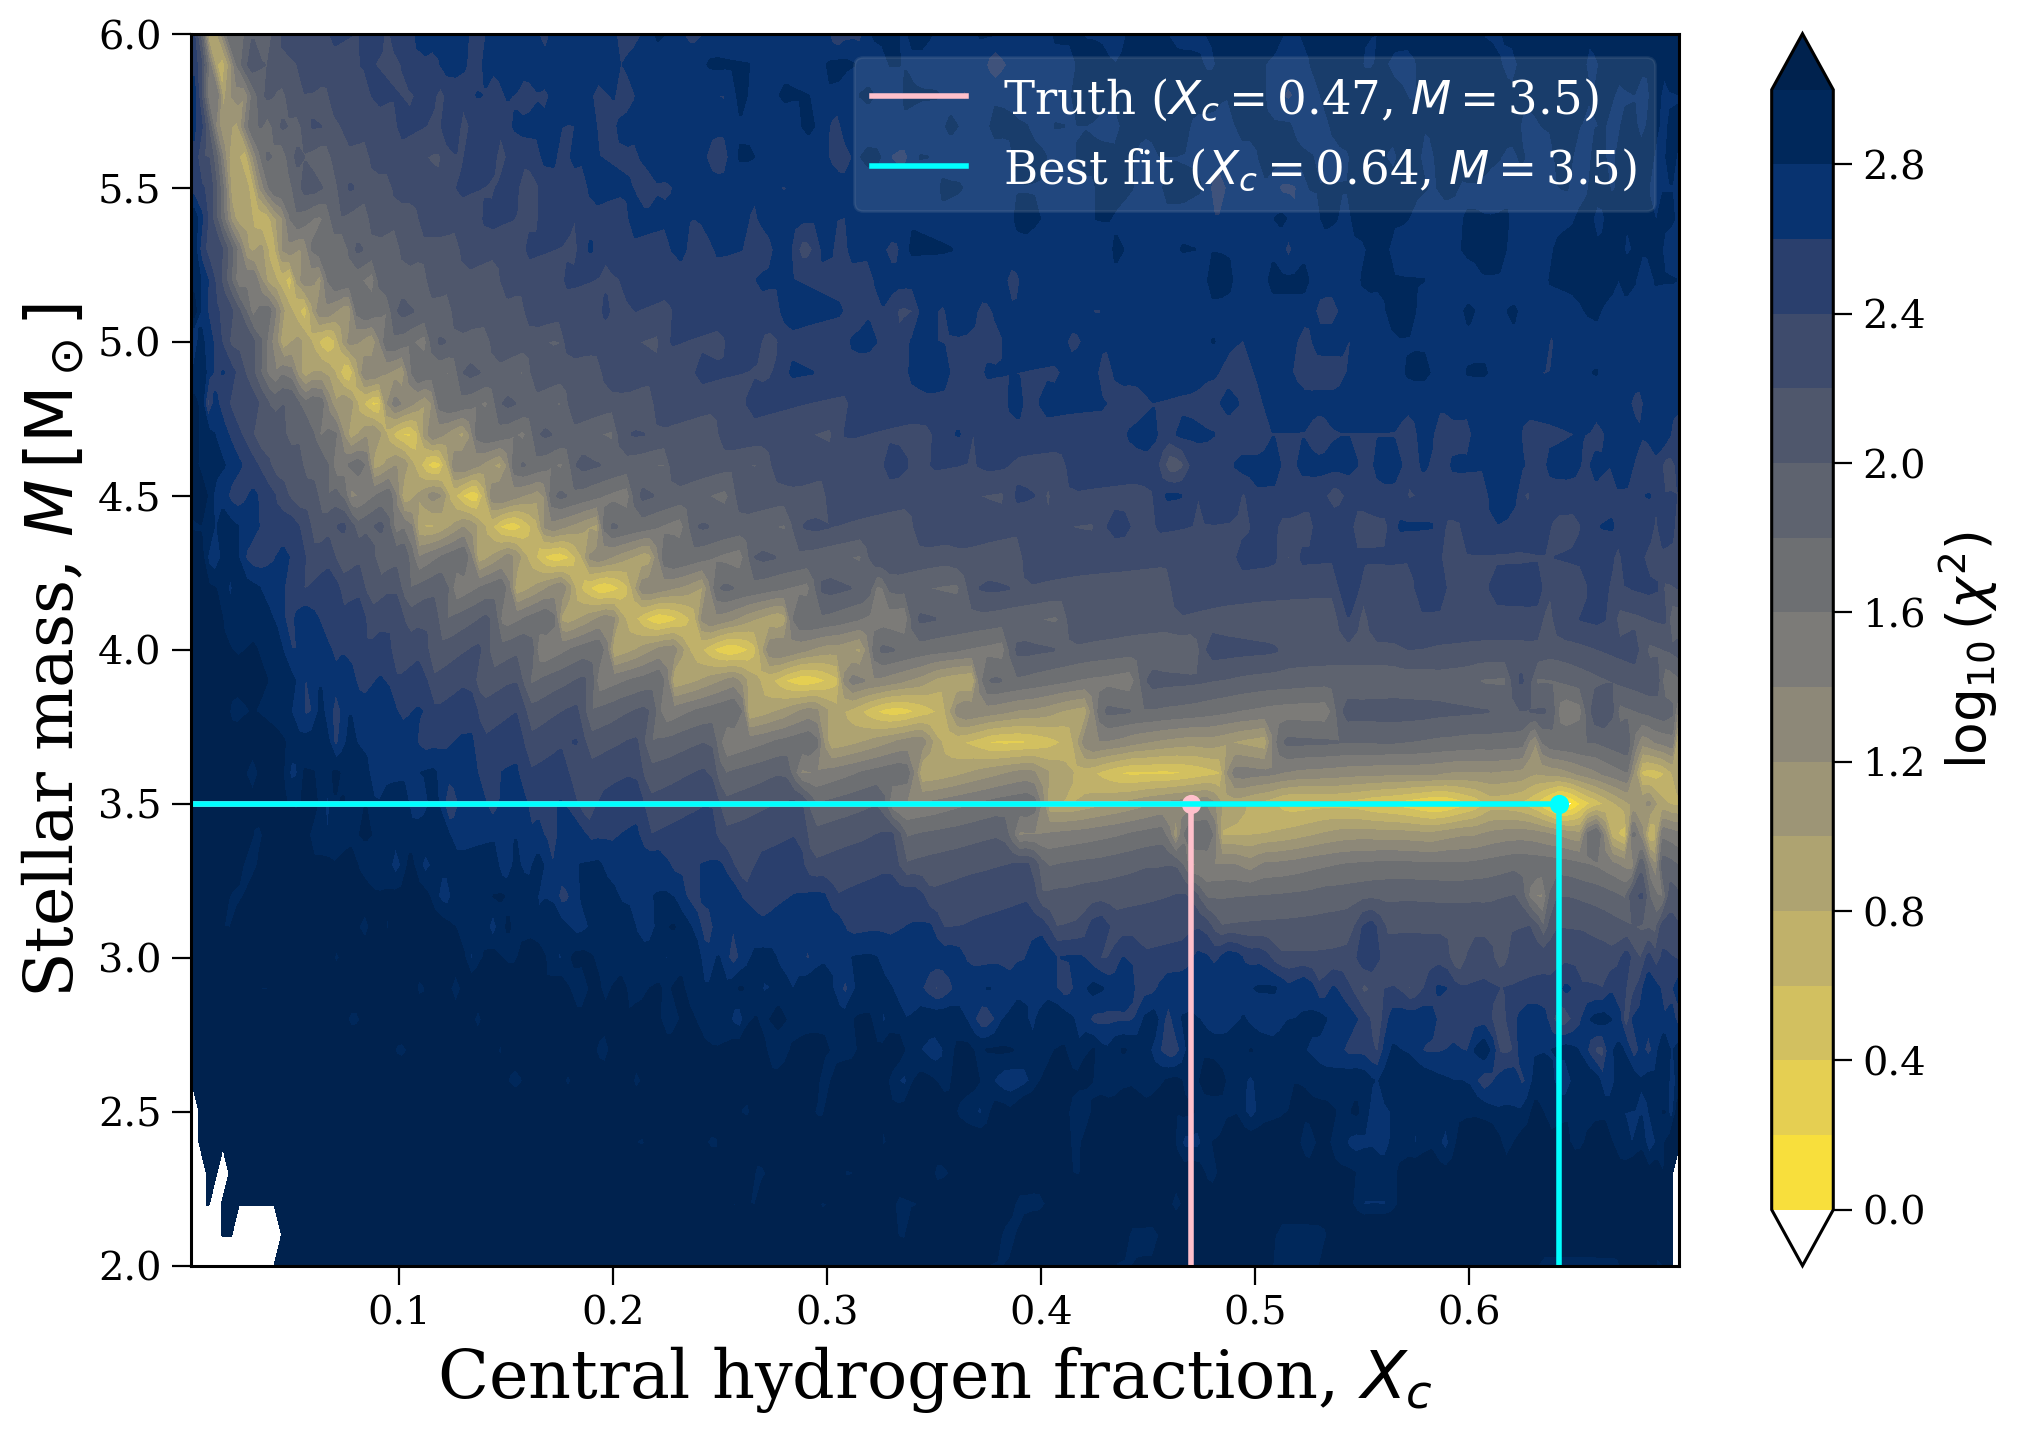

-0.5880785217201564 inf
0.4 0.417 3.500


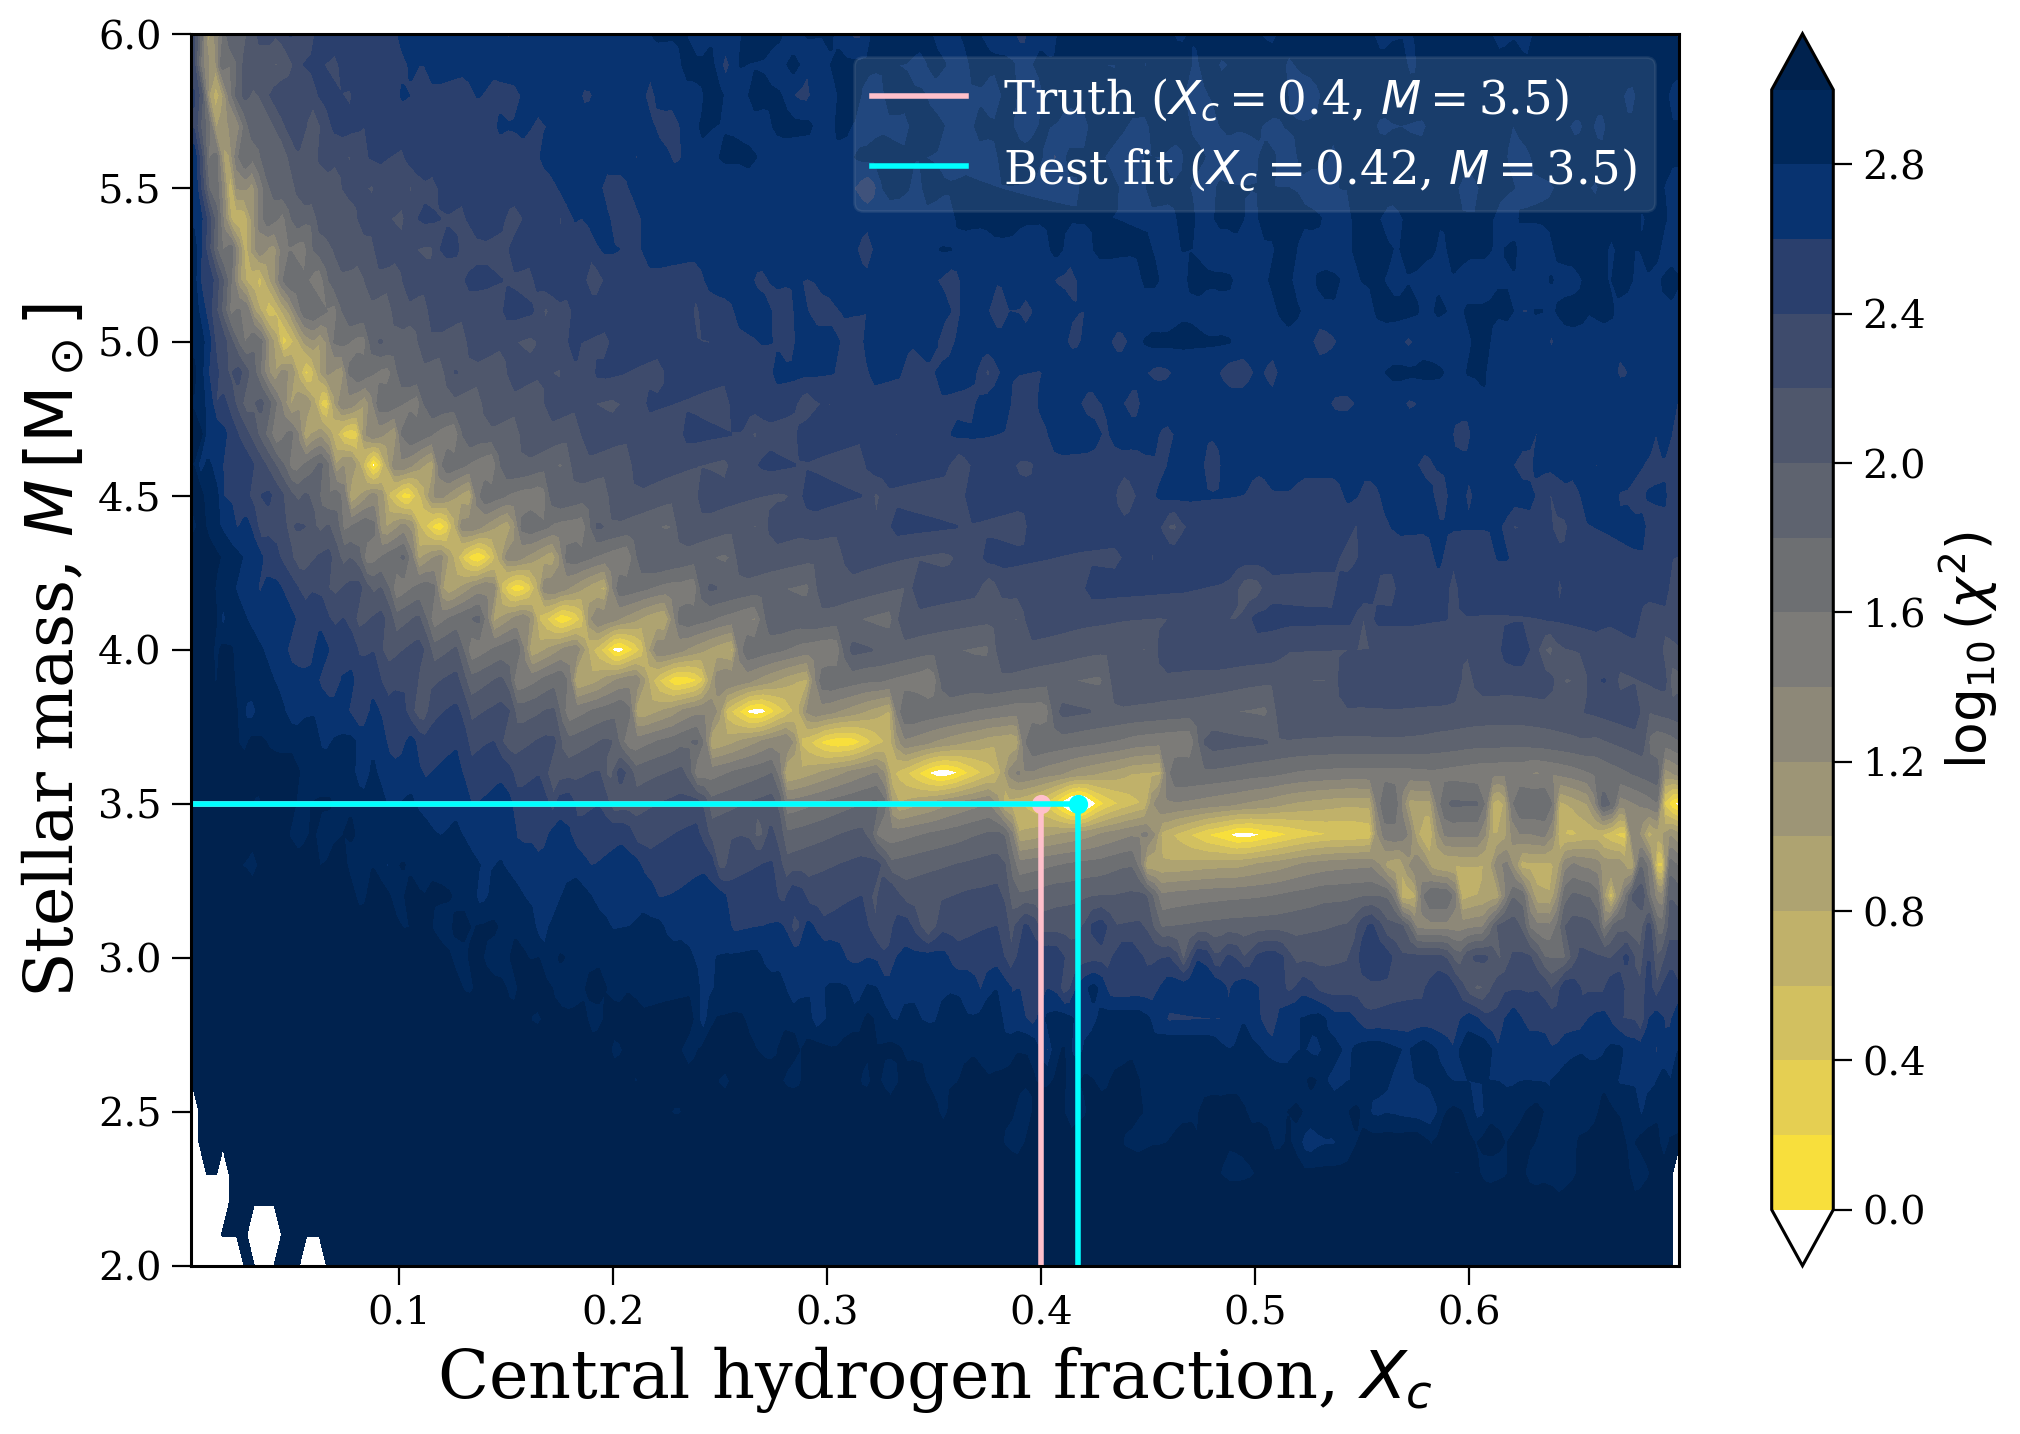

-0.9055122086973615 inf
0.3 0.312 3.500


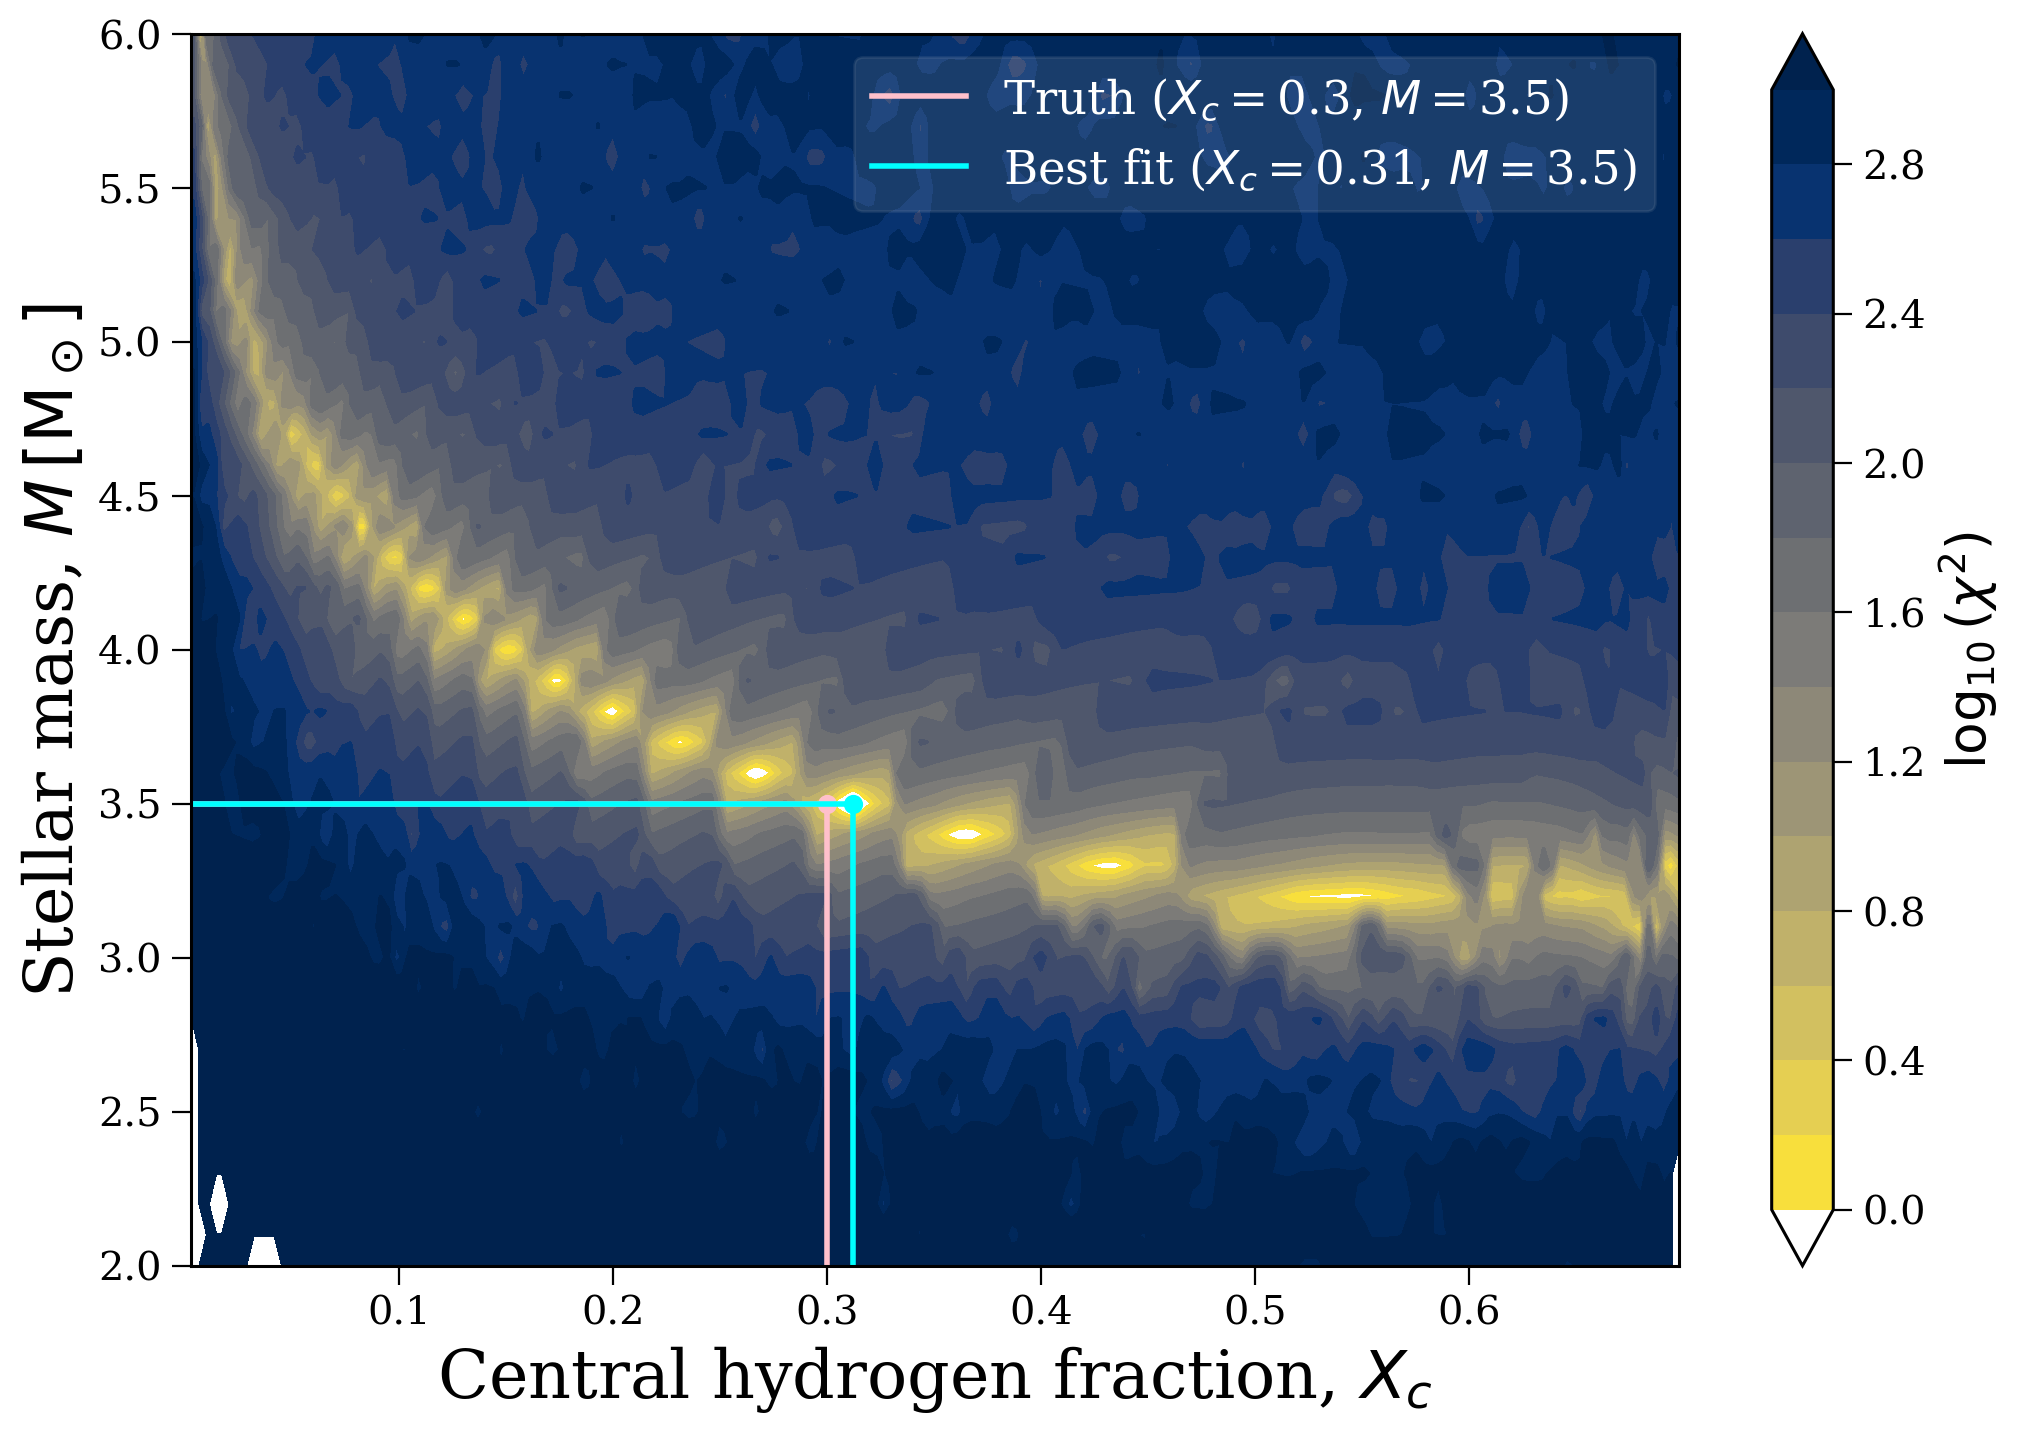

-0.6661647353950257 inf
0.2 0.210 3.500


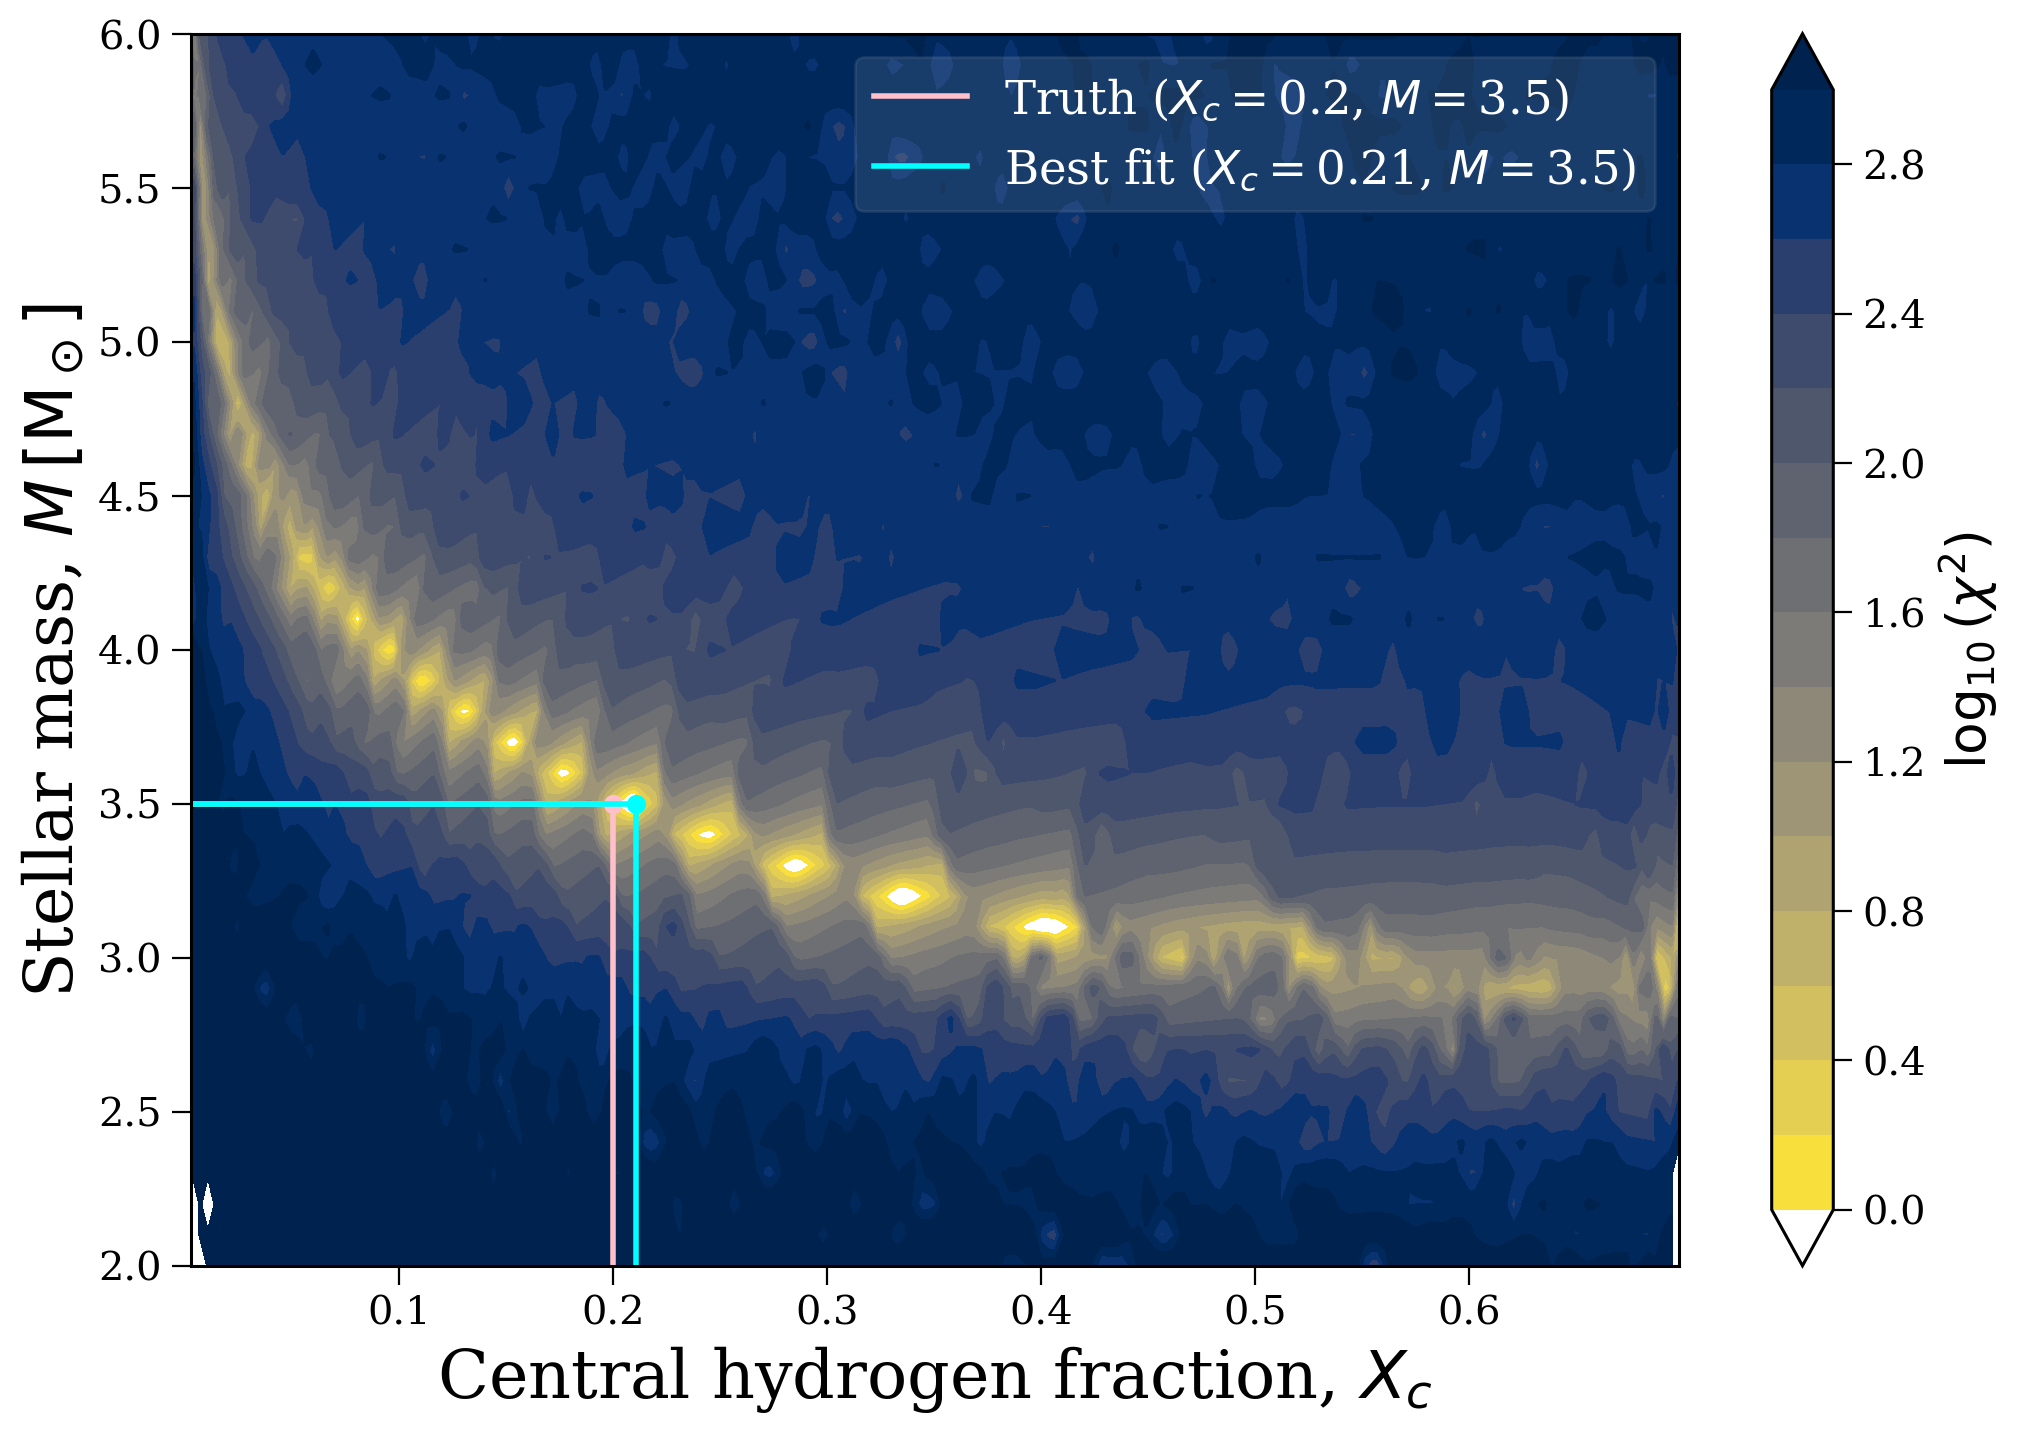

-0.5739485392139594 inf
0.1 0.260 3.000


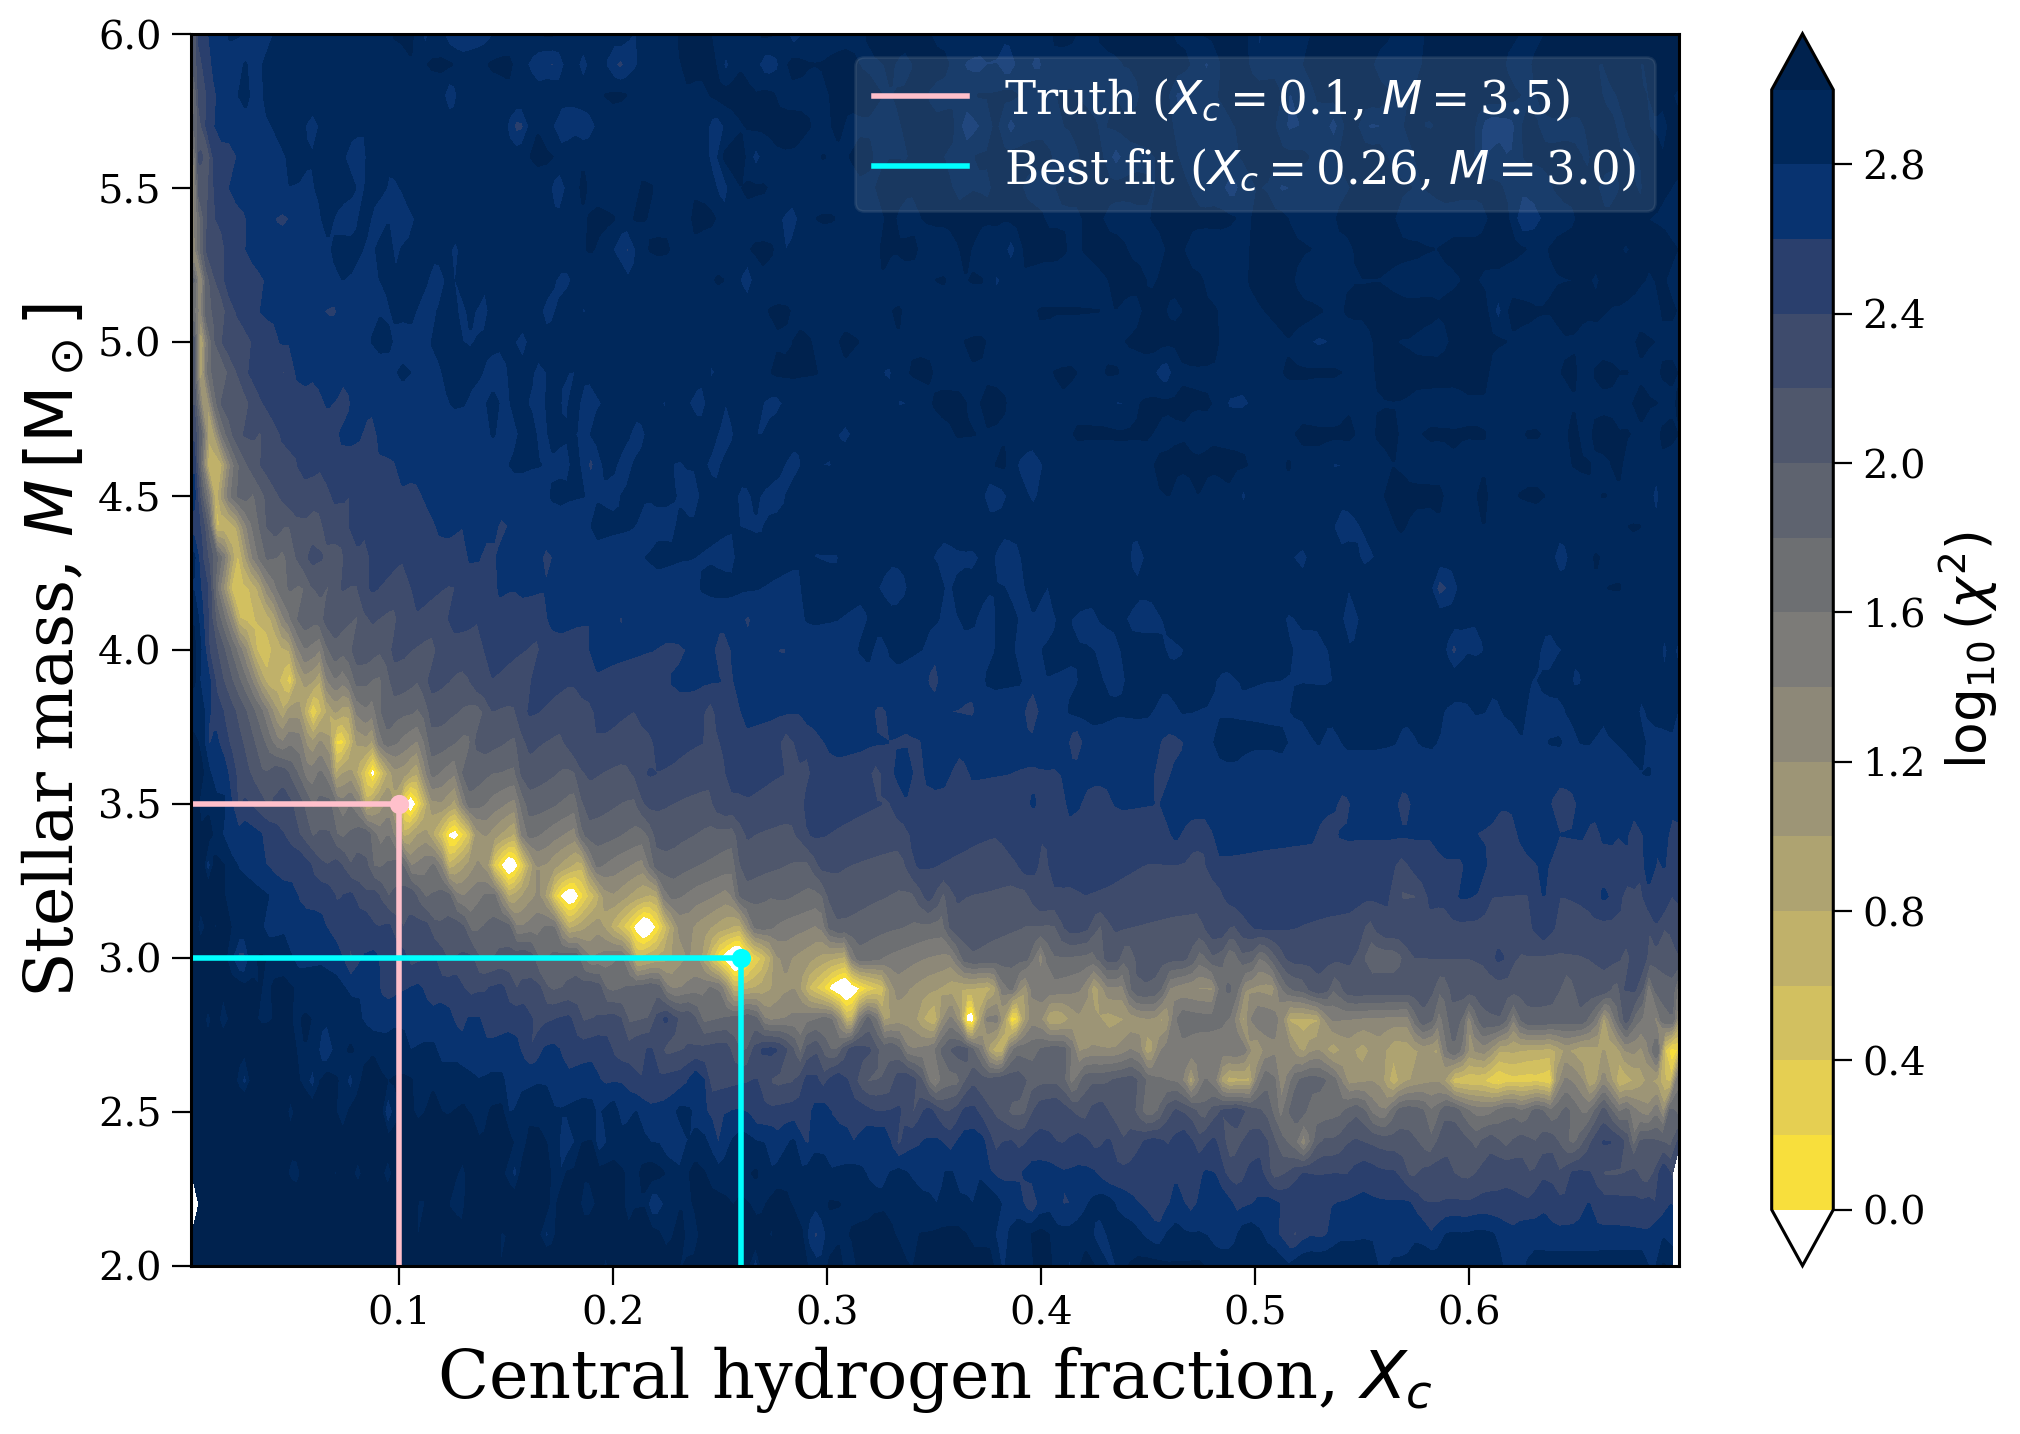

-0.7207917471656418 inf
0.01 0.523 2.000


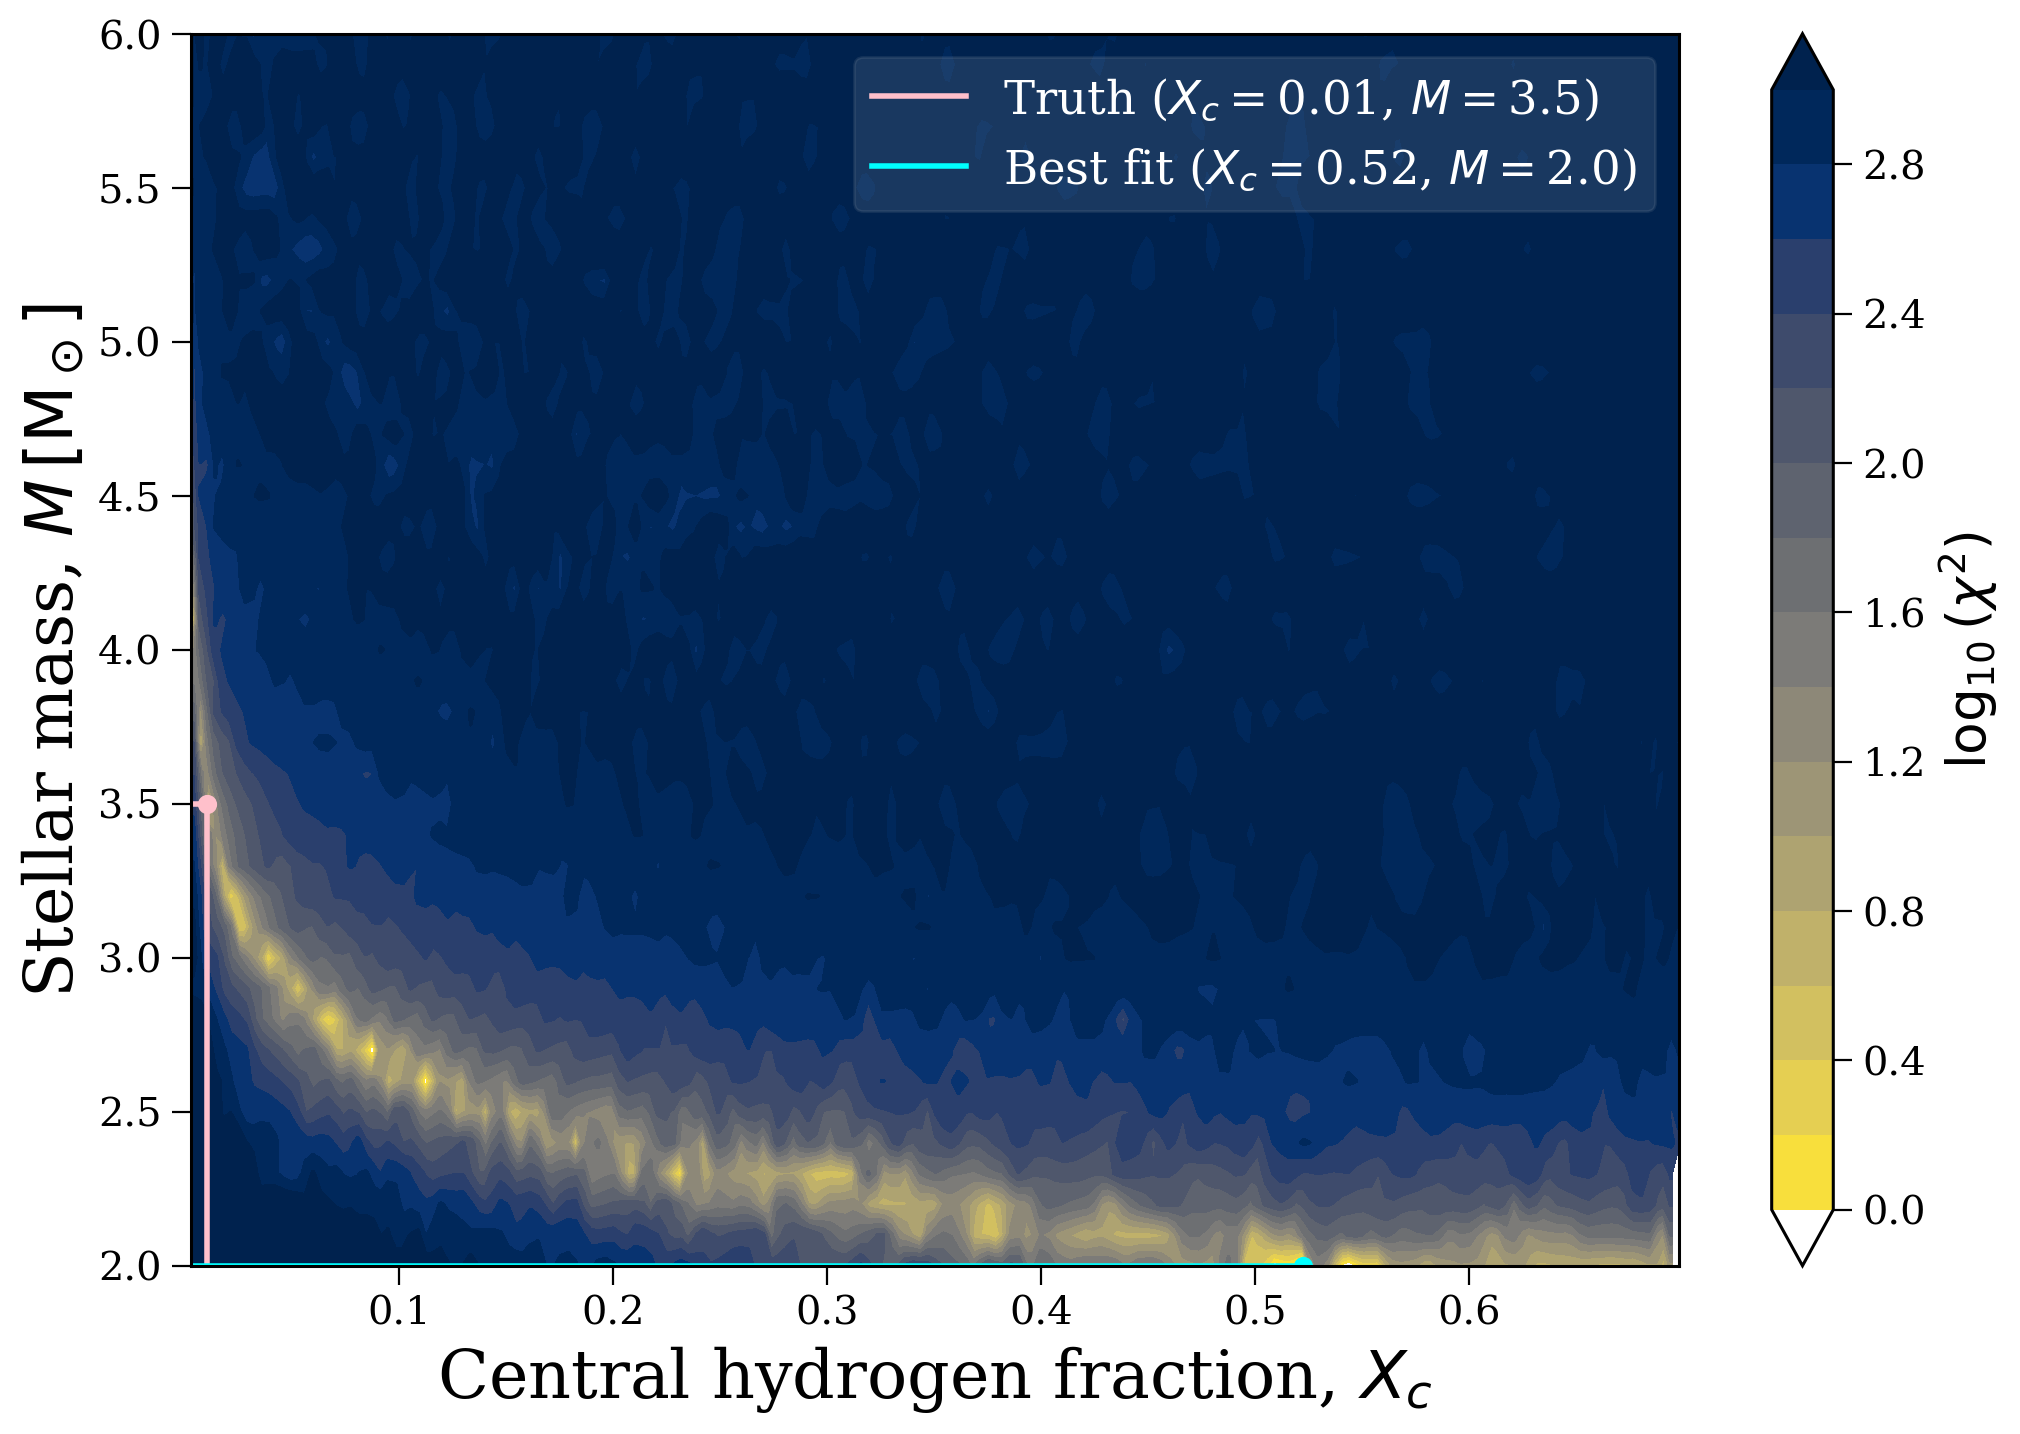

In [23]:
for X_c in [0.47, 0.4, 0.3, 0.2, 0.1, 0.01]:
    chis = get_all_chis(X_c=X_c, reduced=False)
    plot_chis(chis=chis, X_c=X_c)

In [7]:
# OLD
# true_Ms = np.array([3.5, 3.5, 3.5, 3.5, 3.5, 3.5])
# true_Xcs = np.array([0.47, 0.4, 0.3, 0.2, 0.1, 0.01])

# best_Ms = np.array([3.5, 3.5, 3.5, 3.1, 3.0, 3.2])
# best_Xcs = np.array([0.642, 0.417, 0.309, 0.400, 0.256, 0.021])

In [86]:
true_Ms = np.array([3.5, 3.5, 3.5, 3.5, 3.5, 3.5])
true_Xcs = np.array([0.47, 0.4, 0.3, 0.2, 0.1, 0.01])

best_Ms = np.array([3.5, 3.5, 3.5, 3.5, 3.0, 3.0])
best_Xcs = np.array([0.642, 0.417, 0.312, 0.21, 0.26, 0.039])

In [87]:
ages = track.history.loc[mpt.find_closest_model_number(track, X_c=[0.47, 0.4, 0.3, 0.2, 0.1, 0.01])]["star_age"].values

In [88]:
from scipy.interpolate import interp1d

In [89]:
X_c_to_ages = interp1d(true_Xcs, ages / 1e6, fill_value="extrapolate")
ages_to_X_c = interp1d(ages, true_Xcs / 1e6, fill_value="extrapolate")

In [90]:
import matplotlib as mpl

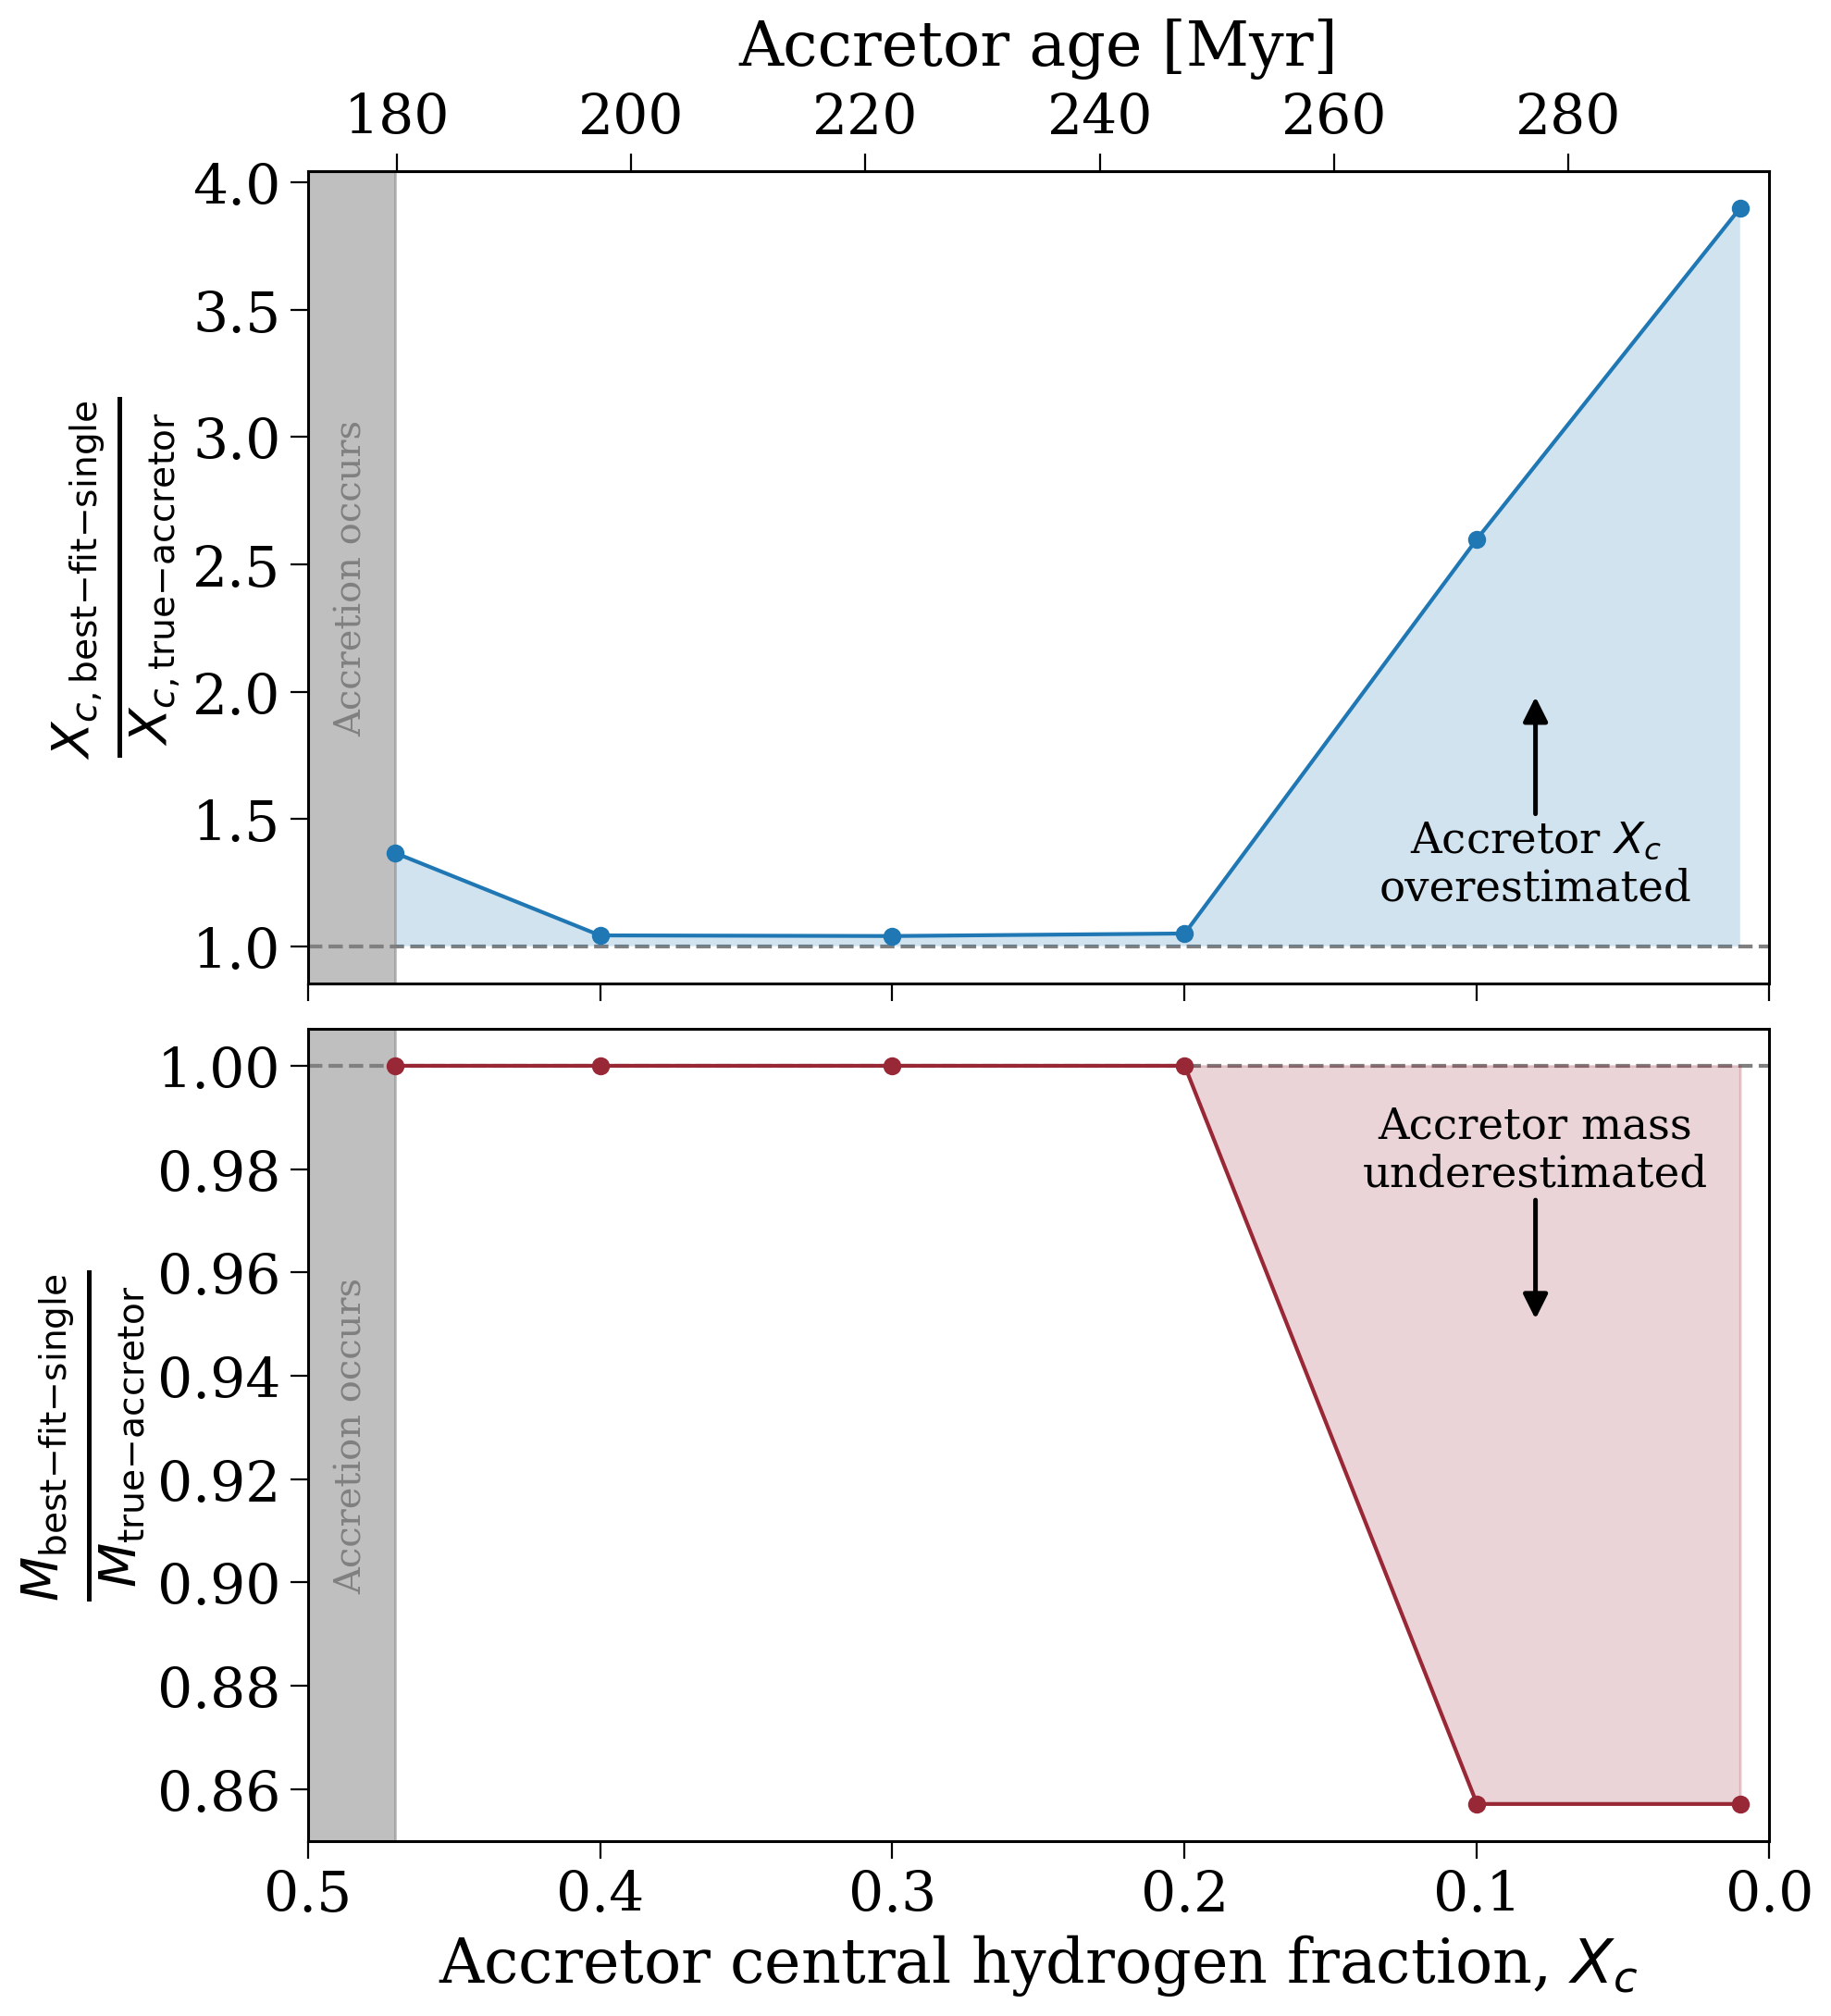

In [100]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

fig, axes = plt.subplots(2, 1, figsize=(10, 11), sharex=True, layout='tight')

axes[0].plot(true_Xcs, best_Xcs / true_Xcs, marker='o', label="best fit")
axes[0].fill_between(true_Xcs, 1.0, best_Xcs / true_Xcs, alpha=0.2)

c = "#992837"
axes[1].plot(true_Xcs, best_Ms / true_Ms, marker='o', label="Truth", color=c)
axes[1].fill_between(true_Xcs, best_Ms / true_Ms, 1.0, alpha=0.2, color=c)

for ax in axes:
    ax.axhline(1, color='grey', linestyle='--', zorder=-1)
    ax.axvspan(0.47, 0.51, color="grey", alpha=0.5)
    ylims = ax.get_ylim()
    ax.annotate("Accretion occurs", xy=(0.485, ylims[0] + (ylims[1] - ylims[0]) / 2), color="grey", fontsize=0.6 * fs, rotation=90, ha='center', va='center')
    ax.set_xlim(0.5, 0.0)
    # ax.axvline(0.0, color='grey', linestyle='--', zorder=-1)
    # ax.annotate("End of main sequence", xy=(0.0, ylims[0] + (ylims[1] - ylims[0]) / 2), color="grey", fontsize=0.4 * fs, rotation=90,
    #             ha='center', va='center', bbox=dict(boxstyle="round", color="white", pad=0.0))
    
axes[0].annotate(r"Accretor $X_c$" + "\noverestimated", xy=(0.08, 1.5), ha="center", va="top", fontsize=0.7 * fs)
axes[0].annotate("", xytext=(0.08, 1.5), xy=(0.08, 2), ha="center", va="center", arrowprops=dict(arrowstyle="-|>, head_length=0.8, head_width=0.4", color='black', lw=1.8))
    
axes[1].annotate("Accretor mass\nunderestimated", xy=(0.08, 0.975), ha="center", va="bottom", fontsize=0.7 * fs)
axes[1].annotate("", xytext=(0.08, 0.975), xy=(0.08, 0.95), ha="center", va="center", arrowprops=dict(arrowstyle="-|>, head_length=0.8, head_width=0.4", color='black', lw=1.8))

axes[0].set_ylabel(r"$\frac{X_{c, \rm best{-}fit{-}single}}{X_{c, \rm true{-}accretor}}$", fontsize=1.2*fs)
axes[1].set_xlabel(r"Accretor central hydrogen fraction, $X_c$")
axes[1].set_ylabel(r"$\frac{M_{\rm best{-}fit{-}single}}{M_{\rm true{-}accretor}}$", fontsize=1.2*fs)

secax = axes[0].secondary_xaxis('top', functions=(X_c_to_ages, ages_to_X_c))
secax.set_xlabel(r"Accretor age [Myr]", labelpad=10)

axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
axes[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))

plt.savefig(f"../paper/figures/relative_estimates.pdf", format="pdf", bbox_inches="tight", dpi=300)

plt.show()

# Old unused functions

In [ ]:
def chi2_2D(p_mg, dp_mg, p_s, dp_s, norm=None):
    if norm is None:
        norm = (dp_mg.max() - dp_mg.min()) / (p_mg.max() - p_mg.min())

    p_mg, dp_mg, p_s, dp_s = p_mg.value, dp_mg.value, p_s.value, dp_s.value

    p_diff = (p_mg[:, None] - p_s[None, :])**2
    dp_diff = ((p_mg[:, None] - p_s[None, :]) / norm)**2

    chi2 = np.min(p_diff + dp_diff, axis=1).sum()

    # sanity check
    assert np.isfinite(chi2)

    return chi2

In [ ]:
def chi_fixed_modes(p_s, p_mg=None, x=None, p_min=1.0, n_modes=20):
    """Calculate chi^2 using a fixed number of modes

    Parameters
    ----------
    p_s : `np.ndarray`
        Single star periods
    p_mg : `np.ndarray`, optional
        Mass-gainer periods, by default None
    x : `np.array`, optional
        Sorted and masked mass-gainer periods (for speed-ups), by default None
    p_min : `float`, optional
        Minimum period, by default 1.0
    n_modes : `int`, optional
        Number of modes to select, by default 20

    Returns
    -------
    chi2 : `float`
        chi^2 value
    """
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods and remove units
        p_mg = np.sort(p_mg.to(u.d).value)

        # take the first n modes after period p_min
        x = p_mg[p_mg > p_min][:n_modes]

    # sort single star periods and remove units
    p_s = np.sort(p_s.to(u.d).value)

    # find the closest period to the starting mass-gainer period 
    y_start = np.abs(p_s - x[0]).argmin()

    # get the 20 modes after this matching period
    y = p_s[y_start:y_start + n_modes]

    # if for some reason there aren't 20 modes in either case then return infinity
    if len(y) != len(x) or len(x) != n_modes or len(y) != n_modes:
        return np.inf
    
    # calculate the cost matrix for the periods
    cost_matrix = np.zeros((len(x), len(y)))
    x_ind, y_ind = np.arange(len(x)), np.arange(len(y))
    for i, j in product(x_ind, y_ind):
        cost_matrix[i, j] = abs(x[i] - y[j])

    # use scipy to find the optimal assignment of modes
    opt_assignment = linear_sum_assignment(cost_matrix)

    # calculate chi^2
    measured_periods = x[opt_assignment[0]]
    model_periods = y[opt_assignment[1]]
    return np.sum((measured_periods - model_periods)**2)